
<div style="color:#ffffff;
          font-size:50px;
          font-style:italic;
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	&nbsp; LLM from scratch
</div>
<br>   
<div style="
          font-size:20px;
          text-align:left;
          font-family: 'Palatino';
          ">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Project: LLM from scratch using PyTorch and Python<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Author: George Barrinuevo<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Date: 07/03/2025<br>
</div>

<br><div style="color:#ffffff;
          font-size:30px;
          font-style:italic;
          text-align:left;
          font-family: 'Lucida Bright';
          background:#4686C8;">
  	      &nbsp; Project Notes
</div>
<div style="
          font-size:16px;
          text-align:left;
          font-family: 'Cambria';">
    
<b>Here are my thoughts on this project.</b>
- The purpose of this project is to create a LLM (Large Language Model) from scratch. It uses PyTorch and Python code.
- This LLM model uses the Transformer model with Multi-head Attention. The input text is a small text file obtain from a few sources.
- This model is meant for educational purposes only since the model size and text input size is too small to be of practical use. To convert it to make it usefull requires using a pretrained LLM model where the model and the weights & bias are downloaded which is beyond the scope of this notebook.
- In preparing for this project I did some self-study. I read a LLM book, studied the basics of PyTorch, reviewed tutorials on Transformers, and etc.
<br>

<b>Technical Details</b><br><br>
<u>Input Text</u>
  - The input text is a plain regular text in a file or downloaded from the internet.

<u>Tokenized Text</u>
  - The plain text is split in to sentences. Each sentence is split in to words.

<u>Token IDs</u>
  - Create a vocabulary of text words to token IDs. The words are first sorted alphabetically or by word occurrence frequency. The token IDs are just index numbers that point back to it's correscponding word.
  - Any punctuations are replaced by an <unknown> token ID.

<u>Token Embedding</u>
  - Adds a multidimensional matrix used as trainable weights. The number of rows in this matrix is the size of the vocabulary and the number of columns is the embedding dimensional size.

<u>Positional Encoding</u>
  - This is the position of the word relative to the text sequence using either absolute or relative position methods. This is a matrix which is added to the text embedding matrix.

<u>Input Embeddings</u>
  - The Token Embeddings and the Positional Encoding matrices are added together to create the Input Embeddings, which are trainable weights with position encoded information.

<u>Sliding Window</u>
  - The sliding window method is used to create input and target text used to train the model. The sliding window length is the number of consecutive words to consider. The input text is derived from the sliding window that moves from left to right of the text sequence. The target text is the input text with an offset of 1 shifted one word to the right. The training requires the model to predict the next word in the input text which is known by the target text.

<u>Attention</u>
  - The various types of attention are:
    - Simplified Attention: This has no trainable weights.
    - Self-Attention: This has trainable weights.
    - Causal Attention: This looks only at previous token IDs and does not consider token IDs ahead of the current position. The purpose of this is to not consider future token IDs.
    - Multi-head attention: This simultaneously computes multiple attentions at a time.
  - In this notebook, the Multi-head Attention will be used. This method has weights that use Query, Key, and Value to perform it's calculations.

<u>Shortcut</u>
  - Solves vanishing gradient issue where the gradients become smaller in value when performing back propagation, creating issues while training.
  - A shortcut allows the gradients to skip a layer. This solves the vanishing gradient issue. The vanishing gradient issue is where the gradients get progressively smaller which creates problems for the learning process.

<u>Layer Normalization</u>
  - This normalizes the layers output to have a mean of 0 and variance of 1. This will stabilize and accelerate the training process by reducing the impact of different scales and ranges. It then applies a scale and shift which are learnable parameters to insure the output values can represent a wide range of values.

<u>GELU activation</u>
  - The Gaussian Error Linear Unit (GELU) is an activation function that smooths the output which solves the vanishing gradient issue and improves performance. This is an improvment over the RELU method.

<u>Feed Forward Neural Network</u>
  - This model extends the embedding dimension to higher dimensions. This allows for improved learning from data.
  - It consists of a Linear layer, followed by GELU activation, next by another Linear layer. The first layer will expand the dimensions. The second Linear layer will contract the expanded dimension to the original dimension.
</div>

In [1]:
!pip install torch
!pip install toktoken
!pip install matplotlib
!pip install tensorflow
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install psutil

In [2]:
import os
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from importlib.metadata import version
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow"
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
,numpy version: 2.0.2
,tiktoken version: 0.9.0
,torch version: 2.6.0+cu124
,tensorflow version: 2.18.0


In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [4]:
def create_model(in_cfg):
    class FeedForward(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.layers = nn.Sequential(
                nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
                nn.GELU(),
                nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
            )

        def forward(self, x):
            return self.layers(x)

    class TransformerBlock(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.att = MultiHeadAttention(
                d_in=cfg["emb_dim"],
                d_out=cfg["emb_dim"],
                context_length=cfg["context_length"],
                num_heads=cfg["n_heads"],
                dropout=cfg["drop_rate"],
                qkv_bias=cfg["qkv_bias"])
            self.ff = FeedForward(cfg)
            self.norm1 = nn.LayerNorm(cfg["emb_dim"])
            self.norm2 = nn.LayerNorm(cfg["emb_dim"])
            self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

        def forward(self, x):
            shortcut = x
            x = self.norm1(x)
            x = self.att(x)
            x = self.drop_shortcut(x)
            x = x + shortcut

            shortcut = x
            x = self.norm2(x)
            x = self.ff(x)
            x = self.drop_shortcut(x)
            x = x + shortcut

            return x

    class GPTModel(nn.Module):
        def __init__(self, cfg):
            super().__init__()
            self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
            self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
            self.drop_emb = nn.Dropout(cfg["drop_rate"])

            self.trf_blocks = nn.Sequential(
                *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

            self.final_norm = nn.LayerNorm(cfg["emb_dim"])
            self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

        def forward(self, in_idx):
            batch_size, seq_len = in_idx.shape
            tok_embeds = self.tok_emb(in_idx)
            pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
            x = tok_embeds + pos_embeds
            x = self.drop_emb(x)
            x = self.trf_blocks(x)
            x = self.final_norm(x)
            logits = self.out_head(x)
            return logits

    class MultiHeadAttention(nn.Module):
        def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
            super().__init__()
            assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

            self.d_out = d_out
            self.num_heads = num_heads
            self.head_dim = d_out // num_heads

            self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
            self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
            self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
            self.out_proj = nn.Linear(d_out, d_out)
            self.dropout = nn.Dropout(dropout)
            self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

        def forward(self, x):
            b, num_tokens, d_in = x.shape

            keys = self.W_key(x)
            queries = self.W_query(x)
            values = self.W_value(x)

            keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
            values = values.view(b, num_tokens, self.num_heads, self.head_dim)
            queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

            keys = keys.transpose(1, 2)
            queries = queries.transpose(1, 2)
            values = values.transpose(1, 2)

            attn_scores = queries @ keys.transpose(2, 3)

            mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

            attn_scores.masked_fill_(mask_bool, -torch.inf)

            attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
            attn_weights = self.dropout(attn_weights)

            context_vec = (attn_weights @ values).transpose(1, 2)

            context_vec = context_vec.reshape(b, num_tokens, self.d_out)
            context_vec = self.out_proj(context_vec)  # optional projection

            return context_vec

    model = GPTModel(in_cfg)
    return model

model_obj = create_model(GPT_CONFIG_124M)

In [5]:
class create_data_handler():
    def __init__(self):
        torch.manual_seed(123)
        self.read_file()
        self.tokenizer = tiktoken.get_encoding("gpt2")

    def read_file(self):
        global text_data

        file_path = 'input_text.txt'
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    def text_to_token_ids(self, text, tokenizer):
        encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
        encoded_tensor = torch.tensor(encoded).unsqueeze(0)
        return encoded_tensor

    def token_ids_to_text(self, token_ids, tokenizer):
        flat = token_ids.squeeze(0)
        return tokenizer.decode(flat.tolist())

    class GPTDataset(Dataset):
        def __init__(self, txt, tokenizer, max_length, stride):
            self.input_ids = []
            self.target_ids = []

            token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

            for i in range(0, len(token_ids) - max_length, stride):
                input_chunk = token_ids[i:i + max_length]
                target_chunk = token_ids[i + 1: i + max_length + 1]
                self.input_ids.append(torch.tensor(input_chunk))
                self.target_ids.append(torch.tensor(target_chunk))

        def __len__(self):
            return len(self.input_ids)

        def __getitem__(self, idx):
            return self.input_ids[idx], self.target_ids[idx]

    def create_dataloader_v1(self, txt, batch_size=4, max_length=256,
                            stride=128, shuffle=True, drop_last=True, num_workers=0):
        tokenizer = tiktoken.get_encoding("gpt2")

        dataset = self.GPTDataset(txt, tokenizer, max_length, stride)

        dataloader = DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

        return dataloader

data_obj = create_data_handler()

In [6]:
class trainer_handler():
    def __init__(self):
        self.train_ratio = 0.90
        self.split_idx = int(self.train_ratio * len(text_data))
        self.train_data = text_data[:self.split_idx]
        self.val_data = text_data[self.split_idx:]

        self.train_loader = data_obj.create_dataloader_v1(
            self.train_data,
            batch_size=2,
            max_length=GPT_CONFIG_124M["context_length"],
            stride=GPT_CONFIG_124M["context_length"],
            drop_last=True,
            shuffle=True,
            num_workers=0
        )

        self.val_loader = data_obj.create_dataloader_v1(
            self.val_data,
            batch_size=2,
            max_length=GPT_CONFIG_124M["context_length"],
            stride=GPT_CONFIG_124M["context_length"],
            drop_last=False,
            shuffle=False,
            num_workers=0
        )

    def calc_loss_batch(self, input_batch, target_batch, model, device):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        logits = model(input_batch)
        loss = F.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        return loss

    def calc_loss_loader(self, data_loader, model, device, num_batches=None):
        total_loss = 0.
        if len(data_loader) == 0:
            return float("nan")
        elif num_batches is None:
            num_batches = len(data_loader)
        else:
            num_batches = min(num_batches, len(data_loader))
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = self.calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
        return total_loss / num_batches

    def train_model_simple(self, model, train_loader, val_loader, optimizer, device, num_epochs,
                          eval_freq, eval_iter, start_context, tokenizer):

        train_losses, val_losses, track_tokens_seen = [], [], []
        tokens_seen, global_step = 0, -1

        for epoch in range(num_epochs):
            model.train()

            for input_batch, target_batch in train_loader:
                optimizer.zero_grad()
                loss = trainer_obj.calc_loss_batch(input_batch, target_batch, model, device)
                loss.backward()
                optimizer.step()
                tokens_seen += input_batch.numel()
                global_step += 1

                if global_step % eval_freq == 0:
                    train_loss, val_loss = self.evaluate_model(
                        model, train_loader, val_loader, device, eval_iter)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    track_tokens_seen.append(tokens_seen)
                    print(f"Ep {epoch+1} (Step {global_step:06d}): "
                          f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            self.generate_and_print_sample(
                model, tokenizer, device, start_context
            )

        return train_losses, val_losses, track_tokens_seen

    def evaluate_model(self, model, train_loader, val_loader, device, eval_iter):
        model.eval()
        with torch.no_grad():
            train_loss = self.calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
            val_loss = self.calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        model.train()
        return train_loss, val_loss

    def generate_text_simple(self, model, idx, max_new_tokens, context_size):
        for _ in range(max_new_tokens):

            idx_cond = idx[:, -context_size:]

            with torch.no_grad():
                logits = model(idx_cond)

            logits = logits[:, -1, :]

            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

            idx = torch.cat((idx, idx_next), dim=1)

        return idx

    def generate_and_print_sample(self, model, tokenizer, device, start_context):
        model.eval()
        context_size = model.pos_emb.weight.shape[0]
        encoded = data_obj.text_to_token_ids(start_context, tokenizer).to(device)
        with torch.no_grad():
            token_ids = self.generate_text_simple(
                model=model, idx=encoded,
                max_new_tokens=50, context_size=context_size
            )
        decoded_text = data_obj.token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))
        model.train()

trainer_obj = trainer_handler()

In [9]:
num_epochs = 10

def do_train():
    global train_losses, val_losses, tokens_seen

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_obj.to(device)
    torch.manual_seed(123)
    model_obj.to(device)
    optimizer = torch.optim.AdamW(model_obj.parameters(), lr=0.0004, weight_decay=0.1)

    train_losses, val_losses, tokens_seen = trainer_obj.train_model_simple(
        model_obj, trainer_obj.train_loader, trainer_obj.val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=5, eval_iter=5,
        start_context="Every effort moves you", tokenizer=data_obj.tokenizer
    )

do_train()

Ep 1 (Step 000000): Train loss 0.469, Val loss 7.223
,Ep 1 (Step 000005): Train loss 0.405, Val loss 7.048
,Ep 1 (Step 000010): Train loss 0.393, Val loss 7.174
,Every effort moves you inapplicable to myself any share in the personal emoluments which may be indispensably included in a permanent provision for the executive department; and must accordingly pray that the pecuniary estimates for the station in which I am placed may
,Ep 2 (Step 000015): Train loss 0.284, Val loss 7.277
,Ep 2 (Step 000020): Train loss 0.183, Val loss 7.283
,Ep 2 (Step 000025): Train loss 0.199, Val loss 7.378
,Every effort moves you in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn's "Moon-
,Ep 3 (Step 000030): Train loss 0.124, Val loss 7.415
,Ep 3 (Step 000035): Train loss 0.119, Val loss 7.454
,Ep 3 (Step 000040): Train loss 0.078, Val loss 7.516
,Every effort moves you say.  "I'

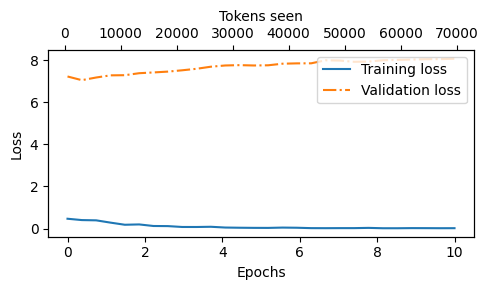

In [10]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)